# 240. CIFAR-10 을 이용한 CNN 구축

- **CNN**을 학습하여 CIFAR-10 데이터베이스의 이미지를 분류합니다.

<img src='https://production-media.paperswithcode.com/datasets/CIFAR-10-0000000431-b71f61c0_U5n3Glr.jpg' width=600 />


- mean, std ((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) 로 normalize 된 image 의 unnormalization 방법
    - image = image * 0.5 + 0.5

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, transforms

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [3]:
BATCH_SIZE = 32
lr = 0.01

## Data Download 및 Data Loader 를 이용하여 Train, Validation data 준비

transforms.ToTensor()의 주요 특징:

1) 데이터 타입 변환: PIL 이미지나 NumPy ndarray를 torch.FloatTensor로 변환  
2) 스케일링: 이미지의 픽셀 값 범위를 [0, 255]에서 [0.0, 1.0]으로 스케일링  
3) 차원 재배열: PyTorch에서는 이미지 데이터를 [C, H, W] 형식(채널, 높이, 너비)으로 처리하므로 입력 이미지 데이터의 차원을 이 형식으로 자동 재배열

In [8]:
# 이미지 데이터에 대한 변환(transform) 조합을 정의
# 이 변환은 이미지 데이터를 증강(augmentation)하고 전처리하는 과정을 포함합니다.
composed = transforms.Compose([
    transforms.RandomHorizontalFlip(),   # 무작위로 수평 뒤집기 수행
    transforms.RandomRotation(10),    # 무작위로 최대 10도 회전
    transforms.ToTensor(),     # 이미지를 PyTorch 텐서로 변환하고 [0.0, 1.0]으로 스케일링
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # 각 채널별 mean)과 std)를 사용하여 정규화 수행
])

# CIFAR10 훈련 데이터셋을 다운로드하고, 위에서 정의한 변환을 적용
train_data = datasets.CIFAR10(root='./data',
                              train=True,
                              download=True,
                              transform=composed)
# CIFAR10 테스트 데이터셋을 다운로드하고, 위에서 정의한 변환을 적용
test_data = datasets.CIFAR10(root='./data',
                             train=False,
                             download=True,
                             transform=composed)

# DataLoader를 사용하여 훈련 데이터셋과 테스트 데이터셋을 배치로 로드합니다.
# shuffle=True는 훈련 데이터 로딩 시 데이터를 무작위로 섞어 오버피팅을 방지하는 데 도움이 됩니다.
train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
# 테스트 데이터 로더에서는 데이터를 섞지 않습니다(shuffle=False).
test_loader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
print(train_data)
print()
print(test_data)
print()
print(train_data[0][0].shape)

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

torch.Size([3, 32, 32])


In [6]:
cifar10_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

### 일부 Data 시각화

- matplotlib 은 channel 위치가 last 이므로 transpose(1, 2, 0) 로 image 수정

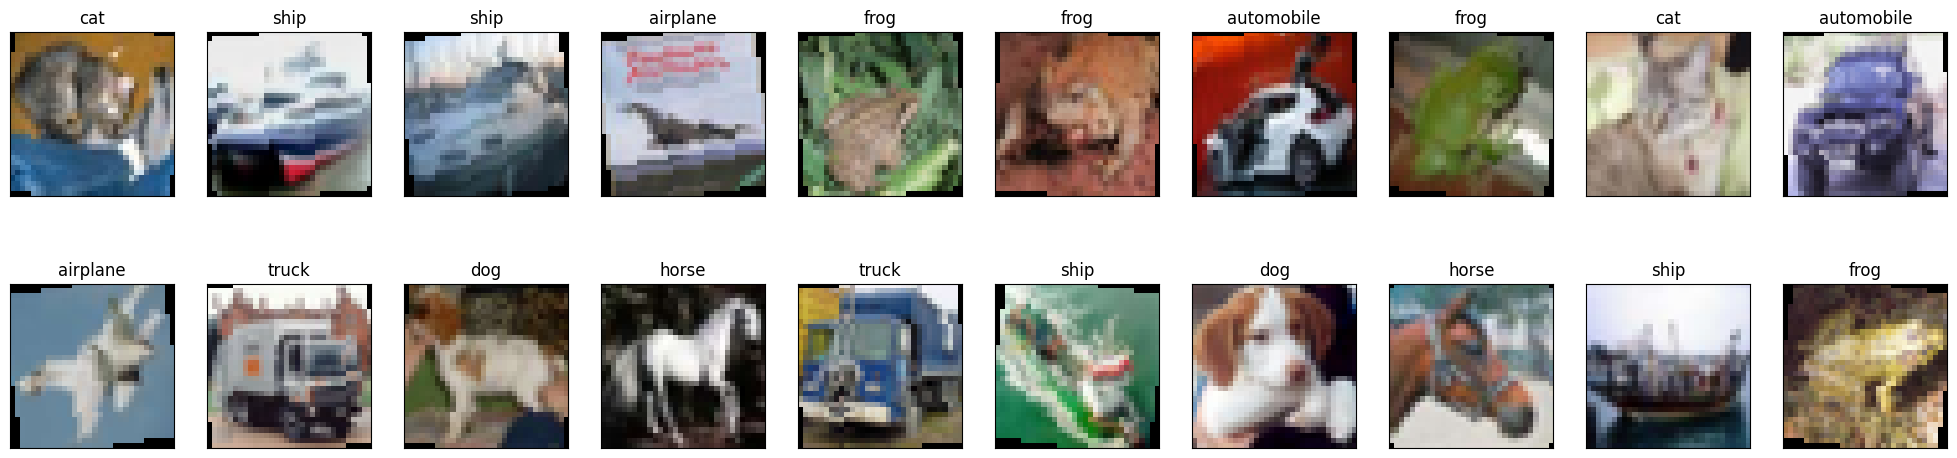

In [9]:
plt.figure(figsize=(25, 6))
for i, (x, y) in enumerate(test_data):
    if i > 19:
        break
    plt.subplot(2, 10, i+1)
    # np.transpose 함수를 사용하여 'x' 텐서의 차원을 재배열
    # (1, 2, 0)은 채널 차원을 마지막으로 이동시키고, 높이와 너비 차원을 앞으로 가져옵니다.
    # 이 형식은 matplotlib와 같은 일부 라이브러리에서 이미지를 표시할 때 요구되는 형식입니다.
    # * 0.5 + 0.5 연산은 정규화를 되돌려 픽셀 값을 원본 범위(0~1)로 unnormalize
    img = np.transpose(x, (1, 2, 0)) * 0.5 + 0.5

    plt.imshow(img)
    plt.title(cifar10_classes[y])
    plt.xticks([])
    plt.yticks([])

plt.show()

## Model build

### Custom Model

- Output Size = (W - F + 2P) / S + 1  
- output_size / Maxpool(2)

In [10]:
def output_size(W, F, P, S, poolsize=1):
    size = (W - F + 2*P)/S + 1
    return size if poolsize == 1 else size / poolsize

input image size : (32, 32)
kernel size : 3
padding : 1
stride : 1

In [11]:
out1 = output_size(32, 3, 1, 1, poolsize=2)
print(out1)
out2 = output_size(out1, 3, 1, 1, poolsize=2)
print(out2)
out3 = output_size(out2, 3, 1, 1, poolsize=2)
out3

16.0
8.0


4.0

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # 3개의 입력 채널을 받아 16개의 출력 채널을 생성
        # 커널 크기는 3, 패딩은 1로 설정하여 입력 이미지의 크기를 유지합니다.
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.conv1_bn = nn.BatchNorm2d(16)  # 첫 번째 합성곱 층의 배치 정규화

        # 16개의 입력 채널을 받아 32개의 출력 채널을 생성
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.conv2_bn = nn.BatchNorm2d(32)  # 두 번째 합성곱 층의 배치 정규화

        # 32개의 입력 채널을 받아 64개의 출력 채널을 생성
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3_bn = nn.BatchNorm2d(64)  # 세 번째 합성곱 층의 배치 정규화

        # 첫 번째 완전 연결 층을 정의합니다. 입력 특징의 수는 4*4*64, 출력 특징의 수는 256입니다.
        self.fc1 = nn.Linear(4*4*64, 256)
        self.fc1_bn = nn.BatchNorm1d(256)  # 첫 번째 완전 연결 층의 배치 정규화
        # 두 번째 완전 연결 층을 정의합니다. 10개의 출력 클래스에 대응합니다.
        self.fc2 = nn.Linear(256, 10)

        self.maxpool = nn.MaxPool2d(2)  # 2x2 최대 풀링 층
        self.relu = nn.ReLU()  # ReLU 활성화 함수
        self.dropout = nn.Dropout(0.25)  # 드롭아웃을 통한 과적합 방지

    def forward(self, x):
        # 합성곱 층과 배치 정규화, ReLU 활성화 함수, 최대 풀링을 차례로 적용
        x = self.relu(self.conv1_bn(self.conv1(x)))
        x = self.maxpool(x)
        x = self.relu(self.conv2_bn(self.conv2(x)))
        x = self.maxpool(x)
        x = self.relu(self.conv3_bn(self.conv3(x)))
        x = self.maxpool(x)

        # 특징 맵을 1차원으로 평탄화
        x = torch.flatten(x, 1)
        # 드롭아웃 적용
        x = self.dropout(x)

        # 완전 연결 층과 배치 정규화, ReLU 활성화 함수 적용
        x = self.relu(self.fc1_bn(self.fc1(x)))
        # 최종 출력 계산
        out = self.fc2(x)

        return out

In [13]:
model = Net()
model = model.to(device)

`model.forward(train_data[0][0].unsqueeze(0).to(device))`

### nn.Sequential 이용


- ``torch.nn`` 에는 코드를 간단히 사용할 수 있는 또 다른 편리한 클래스인
[Sequential](https://pytorch.org/docs/stable/nn.html#torch.nn.Sequential) 이 있습니다.  

- ``Sequential`` 객체는 그 안에 포함된 각 모듈을 순차적으로 실행합니다. 이것은 신경망을 작성하는 더 간단한 방법입니다.


In [14]:
# nn.Sequential을 사용하여 순차적 모델을 정의합니다. 이 방식은 각 레이어를 순서대로 쌓아 올립니다.
model_sequential = nn.Sequential(
    #  3개의 입력 채널(예: RGB 이미지)을 받아 16개의 출력 채널 생성
    # 커널 크기는 3, 스트라이드는 1, 패딩은 1로 설정
    nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
    # 16개의 채널에 대해 배치 정규화 수행
    nn.BatchNorm2d(16),
    # 활성화 함수로 ReLU 사용
    nn.ReLU(),
    # 맥스 풀링 레이어: 커널 크기와 스트라이드를 2로 설정
    nn.MaxPool2d(2, 2),

    # 6개의 입력 채널을 받아 32개의 출력 채널 생성
    nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
    # 32개의 채널에 대해 배치 정규화 수행
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),

    # 32개의 입력 채널을 받아 64개의 출력 채널 생성
    nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
    # 64개의 채널에 대해 배치 정규화 수행
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),

    # 텐서를 1차원으로 평탄화
    nn.Flatten(),
    # 드롭아웃을 적용하여 과적합 방지
    nn.Dropout(0.25),
    # 평탄화된 텐서를 받아 256개의 뉴런을 가진 레이어로 연결
    nn.Linear(1024, 256),
    # 완전 연결 레이어의 배치 정규화
    nn.BatchNorm1d(256),
    nn.ReLU(),
    # 10개의 출력을 가진 레이어로 클래스 분류
    nn.Linear(256, 10) # output: bs x 10
)

### Model Summary

In [15]:
model

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1_bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=1024, out_features=256, bias=True)
  (fc1_bn): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (dropout): Dropout(p=0.25, inplace=False)
)

In [16]:
model_sequential

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU()
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): ReLU()
  (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (12): Flatten(start_dim=1, end_dim=-1)
  (13): Dropout(p=0.25, inplace=False)
  (14): Linear(in_features=1024, out_features=256, bias=True)
  (15): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_

In [18]:
# 두 모델의 파라미터 수가 동일함을 확인
print("model parameters :", sum(p.numel() for p in model.parameters()))

print("model_sequential parameters :", sum(p.numel() for p in model_sequential.parameters()))

model parameters : 289290
model_sequential parameters : 289290


### Loss Function

In [19]:
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=lr)

In [20]:
LOSS, VAL_LOSS, ACC, VAL_ACC = [], [], [], []  # 각 에폭마다의 손실과 정확도를 저장할 리스트

EPOCHS = 10  # 전체 학습 에폭 수 설정

for epoch in range(EPOCHS):

    model.train()  # 모델을 훈련 모드로 설정

    train_loss = 0  # 한 에폭에서의 훈련 손실 누적값 초기화
    train_acc = 0   # 한 에폭에서의 훈련 정확도 누적값 초기화
    for x, y in train_loader:  # 훈련 데이터셋을 배치 단위로 순회
        x, y = x.to(device), y.to(device)  # 배치 데이터를 현재 디바이스로 이동

        optimizer.zero_grad()  # 이전 그라디언트를 초기화
        z = model(x)  # 모델을 통해 예측값 계산
        loss = criterion(z, y)  # 예측값과 실제 레이블 간의 손실 계산
        train_loss += loss.item()  # 손실 누적
        _, y_pred = torch.max(z, 1)  # 가장 높은 예측값의 인덱스를 정답으로 선택
        train_acc += (y_pred == y).sum().item()  # 정확히 예측된 개수 누적

        loss.backward()  # 손실에 대한 그라디언트 계산
        optimizer.step()  # 모델의 가중치 업데이트

    train_loss /= len(train_data)  # 평균 훈련 손실 계산
    train_acc /= len(train_data)   # 평균 훈련 정확도 계산
    LOSS.append(train_loss)
    ACC.append(train_acc)

    model.eval()  # 모델을 평가 모드로 설정

    val_loss = 0  # 검증 손실 누적값 초기화
    val_acc = 0   # 검증 정확도 누적값 초기화
    for x, y in test_loader:  # 테스트(검증) 데이터셋을 배치 단위로 순회
        x, y = x.to(device), y.to(device)

        z = model(x)  # 모델을 통해 예측값 계산
        loss = criterion(z, y)  # 예측값과 실제 레이블 간의 손실 계산

        val_loss += loss.item()  # 손실 누적
        _, y_pred = torch.max(z, 1)  # 가장 높은 예측값의 인덱스를 정답으로 선택
        val_acc += (y_pred == y).sum().item()  # 정확히 예측된 개수 누적

    val_loss /= len(test_data)  # 평균 검증 손실 계산
    val_acc /= len(test_data)  # 평균 검증 정확도 계산
    VAL_LOSS.append(val_loss)
    VAL_ACC.append(val_acc)

    # 에폭별 훈련 및 검증 결과 출력
    print(f'epoch {epoch} ==> train loss: {train_loss:.5f}, validation loss: {val_loss:.5f}, train acc: {train_acc:.5f}, validation acc: {val_acc:.5f}')

epoch 0 ==> train loss: 0.04699, validation loss: 0.03907, train acc: 0.45742, validation acc: 0.55360
epoch 1 ==> train loss: 0.03819, validation loss: 0.03334, train acc: 0.56466, validation acc: 0.62230
epoch 2 ==> train loss: 0.03453, validation loss: 0.03265, train acc: 0.60818, validation acc: 0.63090
epoch 3 ==> train loss: 0.03205, validation loss: 0.02827, train acc: 0.63746, validation acc: 0.68270
epoch 4 ==> train loss: 0.03026, validation loss: 0.02721, train acc: 0.65594, validation acc: 0.69750
epoch 5 ==> train loss: 0.02897, validation loss: 0.02760, train acc: 0.67420, validation acc: 0.69030
epoch 6 ==> train loss: 0.02807, validation loss: 0.02847, train acc: 0.68260, validation acc: 0.67990
epoch 7 ==> train loss: 0.02694, validation loss: 0.02570, train acc: 0.69594, validation acc: 0.71190
epoch 8 ==> train loss: 0.02628, validation loss: 0.02498, train acc: 0.70384, validation acc: 0.72230
epoch 9 ==> train loss: 0.02547, validation loss: 0.02355, train acc: 0.7

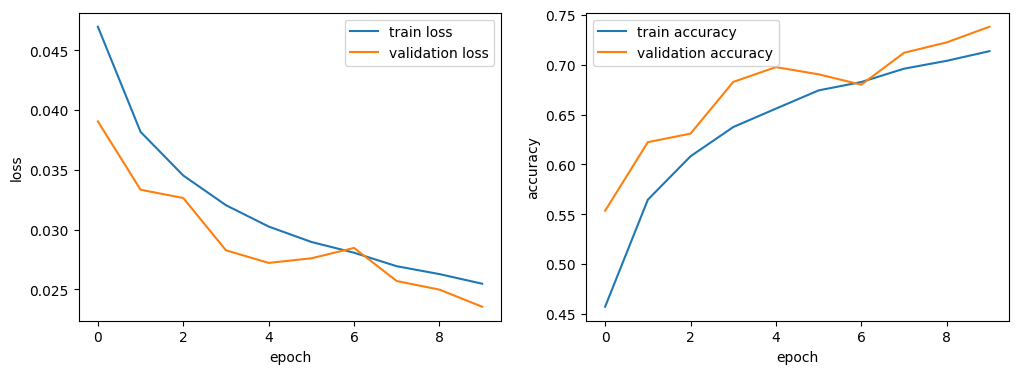

In [21]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot(LOSS, label='train loss')
ax1.plot(VAL_LOSS, label='validation loss')
ax1.set_xlabel('epoch')
ax1.set_ylabel('loss')
ax1.legend()
ax2.plot(ACC, label='train accuracy')
ax2.plot(VAL_ACC, label='validation accuracy')
ax2.set_xlabel('epoch')
ax2.set_ylabel('accuracy')
ax2.legend()

### Model 평가

### model 이 어떤 image 들을 잘 맞추고 혹은 틀렸는지 시각화

In [22]:
predictions = []  # 모델 예측값을 저장할 리스트
labels = []       # 실제 레이블값을 저장할 리스트

model.eval()  # 모델을 평가 모드로 설정

# 테스트 데이터셋을 배치 단위로 순회
for x, y in test_loader:
    x, y = x.to(device), y.to(device)  # 데이터를 현재 디바이스로 이동
    z = model(x)  # 모델을 통해 예측값 계산
    _, y_pred = torch.max(z, 1)  # 예측값 중 가장 높은 값을 가진 인덱스를 선택
    predictions.extend(y_pred.cpu().numpy())  # 예측된 인덱스를 CPU로 이동한 후 numpy 배열로 변환하여 predictions 리스트에 추가
    labels.extend(y.cpu().numpy())  # 실제 레이블을 CPU로 이동한 후 numpy 배열로 변환하여 labels 리스트에 추가

# 예측값과 실제 레이블이 일치하는 경우의 인덱스를 찾음
correct_indices = np.nonzero(np.array(predictions) == np.array(labels))[0]
# 예측값과 실제 레이블이 불일치하는 경우의 인덱스를 찾음
incorrect_indices = np.nonzero(np.array(predictions) != np.array(labels))[0]

# 정확도 계산: 정확한 예측의 수를 전체 예측의 수로 나눈 후 100을 곱하여 백분율로 변환
accuracy = len(correct_indices) / len(predictions) * 100
print(f"accuracy = {accuracy:.2f}%")

accuracy = 73.74%


Text(70.72222222222221, 0.5, 'Predicted Value')

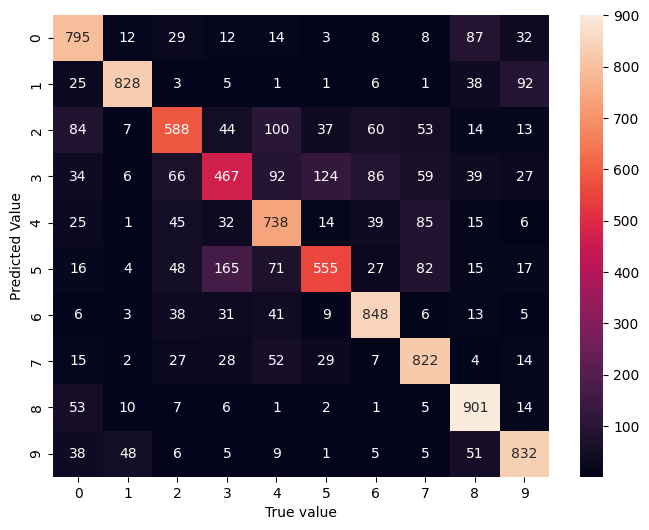

In [23]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(labels, predictions)
plt.figure(figsize=(8, 6))
ax = sns.heatmap(cm, annot=True, fmt='d')
ax.set_xlabel('True value')
ax.set_ylabel('Predicted Value')

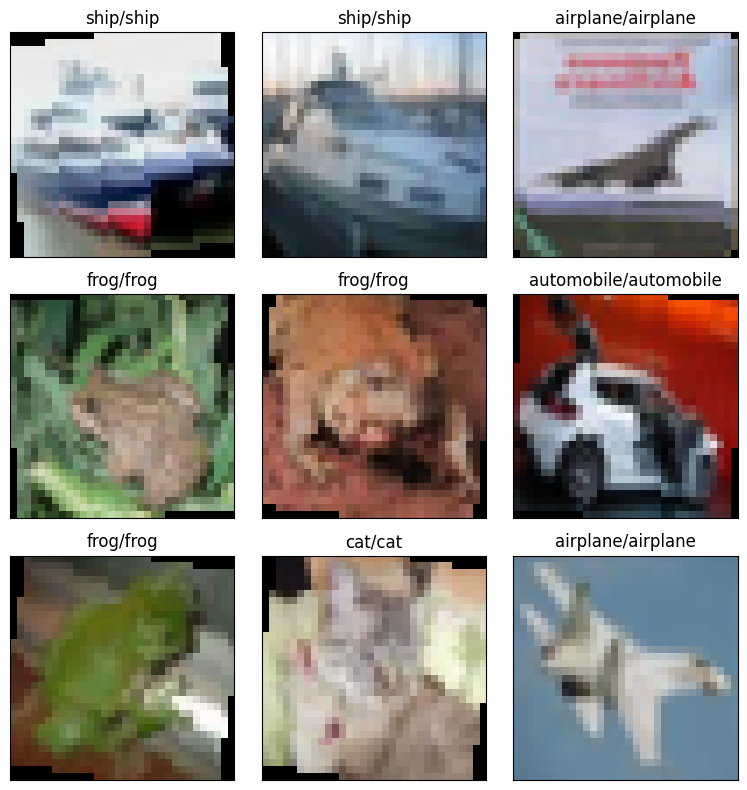

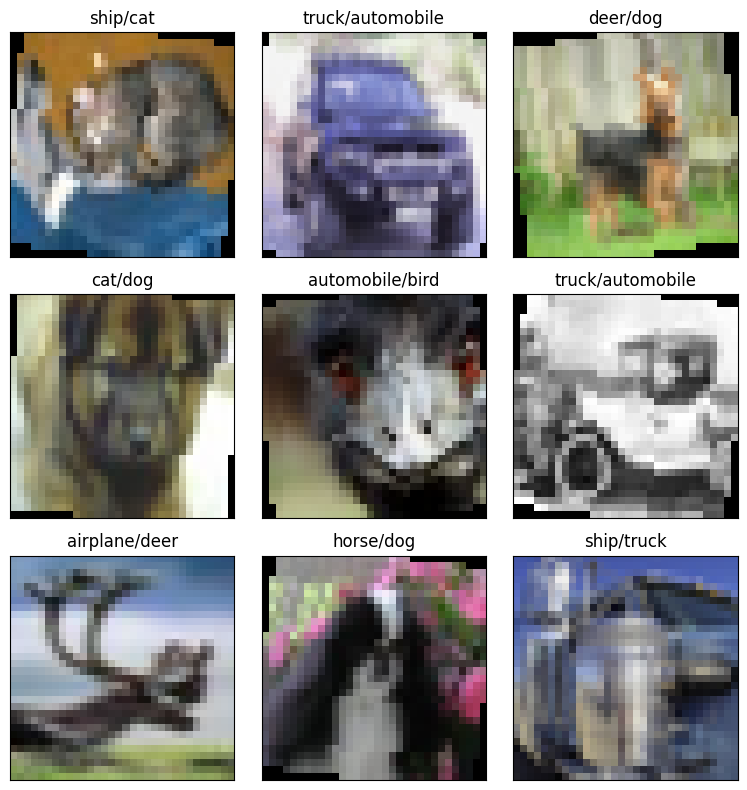

In [24]:
plt.figure(figsize=(8, 8))
# 정확한 예측의 인덱스에서 처음 9개를 순회합니다.
for i, idx in enumerate(correct_indices[:9]):
    plt.subplot(3, 3, i+1)
    img = np.transpose(test_data[idx][0], (1, 2, 0)) / 2 + 0.5  # 이미지 정규화를 되돌리고, 차원을 재배열
    plt.imshow(img)
    plt.title("{}/{}".format(cifar10_classes[predictions[idx]], cifar10_classes[labels[idx]]))  # 예측 레이블/실제 레이블을 제목으로 표시
    plt.xticks([])  # x축 눈금 제거
    plt.yticks([])  # y축 눈금 제거
    plt.tight_layout()  # 서브플롯 간격을 자동으로 조정

plt.figure(figsize=(8, 8))
 # 잘못된 예측의 인덱스에서 처음 9개를 순회합니다.
for i, idx in enumerate(incorrect_indices[:9]):
    plt.subplot(3, 3, i+1)
    img = np.transpose(test_data[idx][0], (1, 2, 0)) / 2 + 0.5
    plt.imshow(img)
    plt.title("{}/{}".format(cifar10_classes[predictions[idx]], cifar10_classes[labels[idx]]))
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

## Saving and loading the model

### Save and load the model via state_dict

In [25]:
PATH = 'cifar10-cnn.pth'
torch.save(model.state_dict(), PATH)

In [27]:
# 'Net' 클래스로부터 모델 인스턴스 생성
model = Net()

# 'load_state_dict()' 메서드를 사용하여 로드한 가중치를 현재 모델 인스턴스에 적용합니다.
model.load_state_dict(torch.load(PATH))

# 'eval()' 메서드는 모델을 평가/테스트 모드로 설정하여, 드롭아웃, 배치 정규화 등이
# 학습 모드와는 다르게 동작하도록 합니다.
model.eval()

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1_bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=1024, out_features=256, bias=True)
  (fc1_bn): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (dropout): Dropout(p=0.25, inplace=False)
)

In [28]:
model = Net()  # Net 클래스의 인스턴스를 생성
model.load_state_dict(torch.load(PATH))  # 사전 학습된 모델의 가중치 로드
model.eval()  # 모델을 평가 모드로 설정

z = model(next(iter(test_loader))[0])  # 테스트 데이터 로더에서 첫 번째 배치의 데이터를 모델에 입력
_, y_pred = torch.max(z, 1)  # 모델의 출력에서 가장 높은 값을 가진 인덱스를 얻습니다.

print(y_pred)  # 예측된 클래스의 인덱스 출력
print(next(iter(test_loader))[1])  # 첫 번째 배치의 실제 레이블 출력

tensor([8, 8, 8, 0, 6, 6, 1, 6, 3, 1, 0, 9, 5, 7, 9, 8, 5, 7, 8, 6, 7, 0, 4, 9,
        4, 4, 4, 2, 9, 6, 6, 5])
tensor([3, 8, 8, 0, 6, 6, 1, 6, 3, 1, 0, 9, 5, 7, 9, 8, 5, 7, 8, 6, 7, 0, 4, 9,
        5, 2, 4, 0, 9, 6, 6, 5])


### Save and load entire model

In [29]:
PATH = "entire_model.pt"
# Save
torch.save(model, PATH)

In [31]:
model = torch.load(PATH)  # PATH 경로에서 전체 모델을 불러옵니다. 이는 모델 구조와 가중치가 포함되어 있습니다.
model.eval()

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1_bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=1024, out_features=256, bias=True)
  (fc1_bn): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (dropout): Dropout(p=0.25, inplace=False)
)

In [32]:
z = model(next(iter(test_loader))[0])
_, y_pred = torch.max(z, 1)

print(y_pred)
print(next(iter(test_loader))[1])

tensor([8, 8, 8, 0, 4, 6, 1, 6, 3, 1, 0, 9, 3, 7, 9, 8, 5, 7, 8, 6, 7, 0, 4, 9,
        4, 2, 4, 2, 9, 6, 6, 5])
tensor([3, 8, 8, 0, 6, 6, 1, 6, 3, 1, 0, 9, 5, 7, 9, 8, 5, 7, 8, 6, 7, 0, 4, 9,
        5, 2, 4, 0, 9, 6, 6, 5])
